In [1]:
sim_res = 1e9
awg_res = 5e8

# Quantum Volume

In [2]:
import tensorflow as tf

2024-04-19 14:21:44.110506: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-19 14:21:44.111970: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 14:21:44.141933: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 14:21:44.142312: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 14:21:44.756260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
from qiskit.circuit.library import QuantumVolume as QuantumVolumeCircuit


In [4]:
qv_circuit = QuantumVolumeCircuit(4, depth=4, seed=24)
qv_circuit.draw()

┌──────────────────────────┐
q_0: ┤0                         ├
     │                          │
q_1: ┤1                         ├
     │  quantum_volume_[4,4,24] │
q_2: ┤2                         ├
     │                          │
q_3: ┤3                         ├
     └──────────────────────────┘

In [5]:
qv_circuit.decompose().draw()

┌──────────┐┌──────────┐┌──────────┐┌──────────┐            
q_0: ────────────┤0         ├┤1         ├┤0         ├┤0         ├────────────
     ┌──────────┐│          ││  su4_751 ││  su4_784 ││          │┌──────────┐
q_1: ┤0         ├┤          ├┤0         ├┤1         ├┤  su4_506 ├┤0         ├
     │  su4_330 ││  su4_383 │├──────────┤├──────────┤│          ││          │
q_2: ┤1         ├┤          ├┤1         ├┤0         ├┤1         ├┤  su4_128 ├
     └──────────┘│          ││  su4_405 ││  su4_575 │└──────────┘│          │
q_3: ────────────┤1         ├┤0         ├┤1         ├────────────┤1         ├
                 └──────────┘└──────────┘└──────────┘            └──────────┘

Transpile the circuit to the native gates

In [6]:
from qiskit import transpile
decomposed_circuit = transpile(qv_circuit, basis_gates=["rx", "ry", "cz"], optimization_level=3)
decomposed_circuit.draw()

global phase: 1.9591
     ┌──────────────┐ ┌────────────┐ ┌───────────┐         ┌────────────┐»
q_0: ┤ Rx(-0.36694) ├─┤ Ry(2.1235) ├─┤ Rx(1.009) ├──────■──┤ Rx(1.2029) ├»
     ├─────────────┬┘┌┴────────────┤┌┴───────────┴┐     │ ┌┴────────────┤»
q_1: ┤ Rx(0.24327) ├─┤ Ry(0.50312) ├┤ Rx(-1.3647) ├──■──┼─┤ Rx(0.91141) ├»
     ├─────────────┤ └┬────────────┤├─────────────┴┐ │  │ └┬────────────┤»
q_2: ┤ Rx(0.41585) ├──┤ Ry(1.8609) ├┤ Rx(0.034328) ├─■──┼──┤ Rx(2.9535) ├»
     ├─────────────┴┐ ├────────────┤├─────────────┬┘    │  ├────────────┤»
q_3: ┤ Rx(-0.63573) ├─┤ Ry(2.4027) ├┤ Rx(-1.2049) ├─────■──┤ Rx(2.8593) ├»
     └──────────────┘ └────────────┘└─────────────┘        └────────────┘»
«                      ┌─────────────┐┌─────────┐ ┌─────────┐      »
«q_0: ───────────────■─┤ Rx(-2.0895) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├────■─»
«                    │ ├─────────────┤├─────────┤ ├─────────┤    │ »
«q_1: ────────────■──┼─┤ Rx(-1.0984) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─■──┼─»
«     ┌─────────┐ │  │ └─┬─────────┬─┘├─────────┴┐└─────────┘ │  │ »
«q_2: ┤ Ry(π/2) ├─■──┼───┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■──┼─»
«     ├─────────┤    │   ├─────────┤  ├──────────┤               │ »
«q_3: ┤ Ry(π/2) ├────■───┤ Rx(π/2) ├──┤ Ry(-π/2) ├───────────────■─»
«     └─────────┘        └─────────┘  └──────────┘                 »
«     ┌─────────────┐  ┌────────────┐┌─────────────┐    ┌─────────────┐»
«q_0: ┤ Rx(-2.1284) ├──┤ Ry(1.6463) ├┤ Rx(-2.5257) ├──■─┤ Rx(0.82587) ├»
«     ├─────────────┴┐┌┴────────────┤└┬────────────┤  │ └┬───────────┬┘»
«q_1: ┤ Rx(-0.60476) ├┤ Ry(0.70816) ├─┤ Rx(2.7899) ├──■──┤ Rx(2.968) ├─»
«     ├──────────────┤└┬────────────┤┌┴────────────┤    ┌┴───────────┴┐»
«q_2: ┤ Rx(-0.16084) ├─┤ Ry(1.4791) ├┤ Rx(0.37687) ├──■─┤ Rx(0.65963) ├»
«     └┬────────────┬┘ ├────────────┤├─────────────┴┐ │ └┬────────────┤»
«q_3: ─┤ Rx(1.6073) ├──┤ Ry(1.3951) ├┤ Rx(-0.43295) ├─■──┤ Rx(2.7258) ├»
«      └────────────┘  └────────────┘└──────────────┘    └────────────┘»
«                   ┌─────────────┐┌─────────┐ ┌─────────┐    ┌────────────┐ »
«q_0: ────────────■─┤ Rx(-1.9244) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─■──┤ Rx(2.3076) ├─»
«     ┌─────────┐ │ └─┬─────────┬─┘├─────────┴┐└─────────┘ │ ┌┴────────────┤ »
«q_1: ┤ Ry(π/2) ├─■───┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■─┤ Rx(0.18526) ├─»
«     └─────────┘   ┌─┴─────────┴─┐├─────────┬┘┌─────────┐   └┬────────────┤ »
«q_2: ────────────■─┤ Rx(-1.0939) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─■──┤ Rx(-1.806) ├─»
«     ┌─────────┐ │ └─┬─────────┬─┘├─────────┴┐└─────────┘ │ ┌┴────────────┴┐»
«q_3: ┤ Ry(π/2) ├─■───┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■─┤ Rx(-0.16248) ├»
«     └─────────┘     └─────────┘  └──────────┘              └──────────────┘»
«     ┌─────────────┐ ┌───────────┐     ┌─────────────┐               »
«q_0: ┤ Ry(0.98107) ├─┤ Rx(1.585) ├───■─┤ Rx(0.40754) ├───────────────»
«     └┬────────────┤┌┴───────────┴┐  │ └─────────────┘┌─────────────┐»
«q_1: ─┤ Ry(2.5167) ├┤ Rx(-1.9465) ├──┼────────■───────┤ Rx(0.50866) ├»
«      ├────────────┤└┬────────────┤  │        │       └┬────────────┤»
«q_2: ─┤ Ry(2.2512) ├─┤ Rx(1.8135) ├──■────────┼────────┤ Rx(2.6092) ├»
«     ┌┴────────────┤┌┴────────────┴┐          │        ├────────────┤»
«q_3: ┤ Ry(0.47464) ├┤ Rx(0.071919) ├──────────■────────┤ Rx(2.7914) ├»
«     └─────────────┘└──────────────┘                   └────────────┘»
«                   ┌─────────────┐  ┌─────────┐  ┌─────────┐               »
«q_0: ────────────■─┤ Rx(-1.4381) ├──┤ Ry(π/2) ├──┤ Rx(π/2) ├─────────────■─»
«                 │ └─────────────┘┌─┴─────────┴─┐├─────────┤ ┌─────────┐ │ »
«q_1: ────────────┼────────■───────┤ Rx(-1.7934) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─┼─»
«     ┌─────────┐ │        │       └─┬─────────┬─┘├─────────┴┐└─────────┘ │ »
«q_2: ┤ Ry(π/2) ├─■────────┼─────────┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■─»
«     ├─────────┤          │         ├─────────┤  ├──────────┤              »
«q_3: ┤ Ry(π/2) ├──────────■─────────┤ Rx(π/2) ├──┤ Ry(-π/2) ├──────────────»
«     └─────────┘                    └─────

In [7]:
decomposed_circuit.measure_all()

## Create Lattice with qruise-toolset

In [8]:
from qruise.toolset.libraries.rydberg.lattice import SquareLattice
r12 = 4.0
lattice = SquareLattice(n_side=2, r_interatomic=r12)
lattice.draw()

In [9]:
from qruise.toolset.libraries.rydberg.rydbergsystem import RydbergSystem
hilbert_dim = 3
ryd_system = RydbergSystem(lattice=lattice, hilbert_dim=hilbert_dim)

In [10]:
rydberg_atom_list = ryd_system.rydberg_atom_list

Create the drives needed in the quantum volume sequence

$R_x$ and $R_y$ gates for all the qubits

In [11]:
import numpy as np
from qruise.toolset.objects import Quantity
phase_yp = Quantity(value=0.5 * np.pi, unit="rads")
phase_xp = Quantity(value=0.0, unit="rads")
phase_xm = Quantity(value=np.pi, unit="rads")
phase_ym = Quantity(value=-0.5 * np.pi, unit="rads")


In [12]:
qubit_names = [atom.name for atom in ryd_system.rydberg_atom_list]
# Global drives for sigle qubit gates
# Rx90p
ryd_system.add_drive(
    "amplitude-phase",
    "rx90p_global",
    channel="raman",
    connected=qubit_names,
    phase=phase_xp,
)
# Rx90m
ryd_system.add_drive(
    "amplitude-phase",
    "rx90m_global",
    channel="raman",
    connected=qubit_names,
    phase=phase_xm,
)
# Ry90p
ryd_system.add_drive(
    "amplitude-phase",
    "ry90p_global",
    channel="raman",
    connected=qubit_names,
    phase=phase_yp,
)
# Ry90m
ryd_system.add_drive(
    "amplitude-phase",
    "ry90m_global",
    channel="raman",
    connected=qubit_names,
    phase=phase_ym,
)

# Local drives for CZ gates
for atom in ryd_system.rydberg_atom_list:
    name = atom.name
    ryd_system.add_drive(
        "amplitude-phase",
        f"rydbergx{name}",
        channel="rydberg",
        connected=[name],
        phase=phase_xp,
    )


In [13]:
for atom in ryd_system.rydberg_atom_list:
    name = atom.name
    print(name)

0
1
2
3


In [14]:
rabi_amplitude = 2e6 # MHz

In [15]:
t_pi_2 = np.around(1 / (4 * rabi_amplitude), 9)
t_pi = np.around(1 / (2 * rabi_amplitude), 9)

In [16]:
t_pi

2.5e-07

Create all possible instructions for the qubits

In [17]:
from qruise.toolset.signal import gates
from qruise.toolset.libraries.rydberg.envelopes import rect_envelope

target_labels = [int(atom.name) for atom in rydberg_atom_list]

gate = gates.Instruction(
    name="rx90p_global",
    t_end=t_pi_2,
    targets=target_labels,
    channels=["rx90p_global"],
    qiskit_name="rx90p",
)
gate.ideal = None
ryd_system.add_instruction(gate,
                           envelope=rect_envelope("rectangular_envelope", amp=2 * np.pi * rabi_amplitude*1e-6, t_final=t_pi_2),
                           drive_name="rx90p_global")
gate = gates.Instruction(
    name="rx90m_global",
    t_end=t_pi_2,
    targets=target_labels,
    channels=["rx90m_global"],
    qiskit_name="rx90m",
)
gate.ideal = None
ryd_system.add_instruction(gate,
                           envelope=rect_envelope("rectangular_envelope", amp= 2 * np.pi * rabi_amplitude*1e-6, t_final=t_pi_2),
                           drive_name="rx90m_global")

gate = gates.Instruction(
    name="ry90p_global",
    t_end=t_pi_2,
    targets=target_labels,
    channels=["ry90p_global"],
    qiskit_name="ry90p",
)
gate.ideal = None
ryd_system.add_instruction(gate,
                           envelope=rect_envelope("rectangular_envelope", amp=2 * np.pi * rabi_amplitude*1e-6, t_final=t_pi_2),
                           drive_name="ry90p_global")
gate = gates.Instruction(
    name="ry90m_global",
    t_end=t_pi_2,
    targets=target_labels,
    channels=["rx90m_global"],
    qiskit_name="ry90m",
)
gate.ideal = None
ryd_system.add_instruction(gate,
                           envelope=rect_envelope("rectangular_envelope", amp= 2 * np.pi * rabi_amplitude*1e-6, t_final=t_pi_2),
                           drive_name="ry90m_global")


# Create all possible combinations for the CZ gates
for atom in rydberg_atom_list:
    ryd_pi = gates.Instruction(
        name=f"ryd_{atom.name}_pi",
        t_end=t_pi,
        channels=[f"rydbergx{atom.name}"],
        targets=[int(atom.name)],
    )
    ryd_pi.ideal = None
    ryd_system.add_instruction(instruction=ryd_pi, 
                               envelope=rect_envelope("rectangular_envelope", 
                                                      amp=2 * np.pi * rabi_amplitude*1e-6, 
                                                    t_final=t_pi), 
                                drive_name=f"rydbergx{atom.name}")
    ryd_2pi = gates.Instruction(
        name=f"ryd_{atom.name}_2pi",
        t_end=2 * t_pi,
        channels=[f"rydbergx{atom.name}"],
        targets=[int(atom.name)],
    )
    ryd_2pi.ideal = None
    ryd_system.add_instruction(instruction=ryd_2pi, 
                               envelope=rect_envelope("rectangular_envelope", amp=2 * np.pi * rabi_amplitude*1e-6, t_final=2 * t_pi), 
                               drive_name=f"rydbergx{atom.name}")

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: global. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: ryd. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: 0. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: pi. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: 2pi. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: 1. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qru

In [18]:
# qv_list = []
# for _ in range(1):
#     qv_circuit = qv_circuit = QuantumVolumeCircuit(4, depth=4)
#     qv_list.append(qv_circuit)
#     decomposed_circuit = transpile(qv_circuit, basis_gates=["rx", "ry", "cz"], optimization_level=3)
#     gate_list = create_instructions(rydberg_system=ryd_system, circuit=decomposed_circuit, rabi_amplitude=rabi_amplitude)


In [19]:
qruise_instructions = ryd_system.instruction_list
qruise_instructions

[Instruction(rx90p_global[0,1,2,3]),
 Instruction(rx90m_global[0,1,2,3]),
 Instruction(ry90p_global[0,1,2,3]),
 Instruction(ry90m_global[0,1,2,3]),
 Instruction(ryd_0_pi[0]),
 Instruction(ryd_0_2pi[0]),
 Instruction(ryd_1_pi[1]),
 Instruction(ryd_1_2pi[1]),
 Instruction(ryd_2_pi[2]),
 Instruction(ryd_2_2pi[2]),
 Instruction(ryd_3_pi[3]),
 Instruction(ryd_3_2pi[3])]

In [20]:
len(ryd_system.instruction_list)

12

In [21]:
len(decomposed_circuit)

119

Collect the model from the Rydberg system

In [22]:
ryd_system.create_model(max_excitations=5)

Set the generator

In [23]:
import qruise.toolset.generator.devices as devices
from qruise.toolset.generator.generator import Generator

ryd_system.sim_res = sim_res
ryd_system.awg_res = awg_res

awg_res = (
    ryd_system.awg_res
)  # number of samples per second; realistic limited resolution of an AWG
v2hz = 1e6
rise_time_value = 100e-9

# create a dict of all the devices
generator_devices = {
    "AWG": devices.AWG(name="awg", resolution=ryd_system.awg_res),
    "DigitalToAnalog": devices.DigitalToAnalog(name="dac"),
    "VoltsToHertz": devices.VoltsToHertz(
        name="v_to_hz", V_to_Hz=Quantity(value=v2hz, unit="Hz/V")
    ),
}

chains = {}
for atom in ryd_system.rydberg_atom_list:
    name = atom.name
    name_rydbergx = f"rydbergx{name}"
    chains[name_rydbergx] = {
        "AWG": [],
        "DigitalToAnalog": ["AWG"],
        "VoltsToHertz": ["DigitalToAnalog"],
    }
chains["rx90p_global"] = {
    "AWG": [],
    "DigitalToAnalog": ["AWG"],
    "VoltsToHertz": ["DigitalToAnalog"],
}
chains["rx90m_global"] = {
    "AWG": [],
    "DigitalToAnalog": ["AWG"],
    "VoltsToHertz": ["DigitalToAnalog"],
}
chains["ry90p_global"] = {
    "AWG": [],
    "DigitalToAnalog": ["AWG"],
    "VoltsToHertz": ["DigitalToAnalog"],
}
chains["ry90m_global"] = {
    "AWG": [],
    "DigitalToAnalog": ["AWG"],
    "VoltsToHertz": ["DigitalToAnalog"],
}
device_generator = Generator(
    devices=generator_devices,
    chains=chains,
)

ryd_system.set_generator(device_generator)

In [24]:
ryd_system.generator.draw(qruise_instructions[-1], resolution=generator_devices["AWG"].resolution, line_shape="vhv")

Create generator

In [25]:
ryd_system.create_experiment()

In [26]:
ryd_system.generator.draw(qruise_instructions[-1], resolution=generator_devices["AWG"].resolution, line_shape="vhv")

In [27]:
an_instruction = ryd_system.instruction_list[-1]
prop = ryd_system.experiment.compute_propagators(gate_ids=[an_instruction.get_key()])

In [28]:
U = prop[an_instruction.get_key()]._tensor

In [29]:
U.shape

TensorShape([66, 66])

In [30]:
ryd_system.experiment.draw_dynamics(sequence=[ryd_system.instruction_list[2].get_key()], state=ryd_system.model.get_init_state())

In [31]:
qruise_experiment = ryd_system.experiment

In [32]:
# qruise_experiment.compute_propagators()

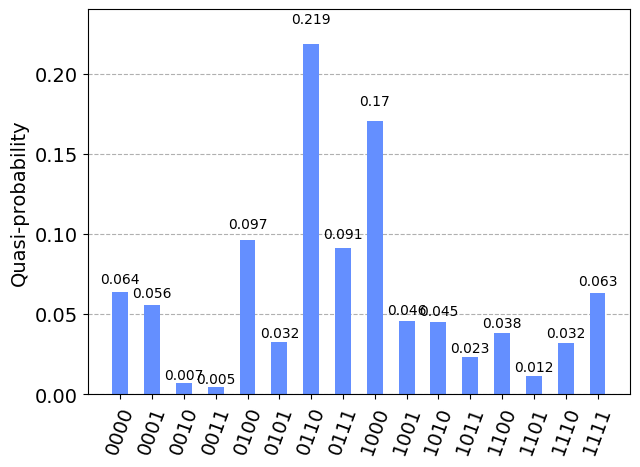

In [33]:
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
ideal_results = Statevector.from_instruction(qv_circuit).probabilities_dict()
plot_histogram(ideal_results)

Qruise backend

In [34]:
from qruise.toolset.libraries.rydberg import RydbergAtom
from qruise.toolset.qiskit import QruiseProvider
qruise_provider = QruiseProvider()
qruise_backend = qruise_provider.get_backend("qruise_qasm_rydberg_simulator")
# Set qubit type to Rydberg atom
qruise_backend.qubit_type = RydbergAtom
qruise_backend.set_qruise_experiment(qruise_experiment)
# qruise_backend._experiment_mode = "quantum_volume"

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/experiment.py:153: UserWarning:

Using default simulation resolution in experiment, make sure this is what you expect (or you have set sim_res in the Instructions)



In [35]:
qruise_backend._experiment_mode = "populations"

In [36]:
def state_transform_function() -> callable:
    def state_transform(
        state: tf.Tensor, gate_dict: dict, reshape_after: bool, reshape_before: bool
    ):
        # Gate dict name
        gate_name = gate_dict["name"]
        if gate_name == "cz":
            atom1 = gate_dict["qubits"][0]
            atom2 = gate_dict["qubits"][1]
            gate_names = [f"ryd_{atom1}_pi", f"ryd_{atom2}_2pi", f"ryd_{atom1}_pi"]
            targets = [[atom1], [atom2], [atom1]]
            for gate_index, gate_specs in enumerate(zip(gate_names, targets)):
                gate_name, gate_targets = gate_specs
                reshape_after = (
                None if reshape_after is None and gate_index == 3 else False
                )
                gate_dict["name"] = gate_name
                gate_dict["qubits"] = gate_targets
                state = qruise_experiment.lookup_propagator(
                    **gate_dict,
                    compute=False,
                ).propagate_state(
                    state, reshape_after=reshape_after, reshape_before=reshape_before
                )
                reshape_before = False
        elif "rx" in gate_name:
            gate_names = ["ry90p_global", "rz", "ry90m_global"]
            targets = [target_labels, gate_dict["qubits"], target_labels]
            for gate_index, gate_specs in enumerate(zip(gate_names, targets)):
                gate_name, gate_targets = gate_specs
                reshape_after = (
                None if reshape_after is None and gate_index == 3 else False
                )
                gate_dict["name"] = gate_name
                gate_dict["qubits"] = gate_targets
                state = qruise_experiment.lookup_propagator(
                    **gate_dict,
                    compute=False,
                ).propagate_state(
                    state, reshape_after=reshape_after, reshape_before=reshape_before
                )
                reshape_before = False
        elif "ry" in gate_name:
            gate_names = ["rx90m_global", "rz", "rx90p_global"]
            targets = [target_labels, gate_dict["qubits"], target_labels]
            for gate_index, gate_specs in enumerate(zip(gate_names, targets)):
                gate_name, gate_targets = gate_specs
                reshape_after = (
                None if reshape_after is None and gate_index == 3 else False
                )
                gate_dict["name"] = gate_name
                gate_dict["qubits"] = gate_targets
                state = qruise_experiment.lookup_propagator(
                    **gate_dict,
                    compute=False,
                ).propagate_state(
                    state, reshape_after=reshape_after, reshape_before=reshape_before
                )
                reshape_before = False
        else:
            raise ValueError("Not supported gate")
        return state

    return state_transform

In [37]:
qruise_backend._state_propagation_function = state_transform_function()

In [38]:
decomposed_circuit.draw()

global phase: 1.9591
        ┌──────────────┐ ┌────────────┐ ┌───────────┐         ┌────────────┐»
   q_0: ┤ Rx(-0.36694) ├─┤ Ry(2.1235) ├─┤ Rx(1.009) ├──────■──┤ Rx(1.2029) ├»
        ├─────────────┬┘┌┴────────────┤┌┴───────────┴┐     │ ┌┴────────────┤»
   q_1: ┤ Rx(0.24327) ├─┤ Ry(0.50312) ├┤ Rx(-1.3647) ├──■──┼─┤ Rx(0.91141) ├»
        ├─────────────┤ └┬────────────┤├─────────────┴┐ │  │ └┬────────────┤»
   q_2: ┤ Rx(0.41585) ├──┤ Ry(1.8609) ├┤ Rx(0.034328) ├─■──┼──┤ Rx(2.9535) ├»
        ├─────────────┴┐ ├────────────┤├─────────────┬┘    │  ├────────────┤»
   q_3: ┤ Rx(-0.63573) ├─┤ Ry(2.4027) ├┤ Rx(-1.2049) ├─────■──┤ Rx(2.8593) ├»
        └──────────────┘ └────────────┘└─────────────┘        └────────────┘»
meas: 4/════════════════════════════════════════════════════════════════════»
                                                                            »
«                         ┌─────────────┐┌─────────┐ ┌─────────┐      »
«   q_0: ───────────────■─┤ Rx(-2.0895) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├────■─»
«                       │ ├─────────────┤├─────────┤ ├─────────┤    │ »
«   q_1: ────────────■──┼─┤ Rx(-1.0984) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─■──┼─»
«        ┌─────────┐ │  │ └─┬─────────┬─┘├─────────┴┐└─────────┘ │  │ »
«   q_2: ┤ Ry(π/2) ├─■──┼───┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■──┼─»
«        ├─────────┤    │   ├─────────┤  ├──────────┤               │ »
«   q_3: ┤ Ry(π/2) ├────■───┤ Rx(π/2) ├──┤ Ry(-π/2) ├───────────────■─»
«        └─────────┘        └─────────┘  └──────────┘                 »
«meas: 4/═════════════════════════════════════════════════════════════»
«                                                                     »
«        ┌─────────────┐  ┌────────────┐┌─────────────┐    ┌─────────────┐»
«   q_0: ┤ Rx(-2.1284) ├──┤ Ry(1.6463) ├┤ Rx(-2.5257) ├──■─┤ Rx(0.82587) ├»
«        ├─────────────┴┐┌┴────────────┤└┬────────────┤  │ └┬───────────┬┘»
«   q_1: ┤ Rx(-0.60476) ├┤ Ry(0.70816) ├─┤ Rx(2.7899) ├──■──┤ Rx(2.968) ├─»
«        ├──────────────┤└┬────────────┤┌┴────────────┤    ┌┴───────────┴┐»
«   q_2: ┤ Rx(-0.16084) ├─┤ Ry(1.4791) ├┤ Rx(0.37687) ├──■─┤ Rx(0.65963) ├»
«        └┬────────────┬┘ ├────────────┤├─────────────┴┐ │ └┬────────────┤»
«   q_3: ─┤ Rx(1.6073) ├──┤ Ry(1.3951) ├┤ Rx(-0.43295) ├─■──┤ Rx(2.7258) ├»
«         └────────────┘  └────────────┘└──────────────┘    └────────────┘»
«meas: 4/═════════════════════════════════════════════════════════════════»
«                                                                         »
«                      ┌─────────────┐┌─────────┐ ┌─────────┐   »
«   q_0: ────────────■─┤ Rx(-1.9244) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─■─»
«        ┌─────────┐ │ └─┬─────────┬─┘├─────────┴┐└─────────┘ │ »
«   q_1: ┤ Ry(π/2) ├─■───┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■─»
«        └─────────┘   ┌─┴─────────┴─┐├─────────┬┘┌─────────┐   »
«   q_2: ────────────■─┤ Rx(-1.0939) ├┤ Ry(π/2) ├─┤ Rx(π/2) ├─■─»
«        ┌─────────┐ │ └─┬─────────┬─┘├─────────┴┐└─────────┘ │ »
«   q_3: ┤ Ry(π/2) ├─■───┤ Rx(π/2) ├──┤ Ry(-π/2) ├────────────■─»
«        └─────────┘     └─────────┘  └──────────┘              »
«meas: 4/═══════════════════════════════════════════════════════»
«                                                               »
«         ┌────────────┐ ┌─────────────┐ ┌───────────┐     ┌─────────────┐»
«   q_0: ─┤ Rx(2.3076) ├─┤ Ry(0.98107) ├─┤ Rx(1.585) ├───■─┤ Rx(0.40754) ├»
«        ┌┴────────────┤ └┬────────────┤┌┴───────────┴┐  │ └─────────────┘»
«   q_1: ┤ Rx(0.18526) ├──┤ Ry(2.5167) ├┤ Rx(-1.9465) ├──┼────────■───────»
«        └┬────────────┤  ├────────────┤└┬────────────┤  │        │       »
«   q_2: ─┤ Rx(-1.806) ├──┤ Ry(2.2512) ├─┤ Rx(1.8135) ├──■────────┼───────»
«        ┌┴────────────┴┐┌┴────────────┤┌┴────────────┴┐          │       »
«   q_3: ┤ Rx(-0.16248) ├┤ Ry(0.47464) ├┤ Rx(0.071919) ├──────────■───────»
«        └──────────────┘└─────────────┘└──────────────┘                  »
«meas: 4/═════════════════════════════════════════════════════════════════»
«      

In [39]:
job_results = qruise_backend.run(decomposed_circuit, shots=1000, memory=True)

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/qiskit/backends.py:332: UserWarning:

The following operations are not supported yet: ['measure', 'barrier']



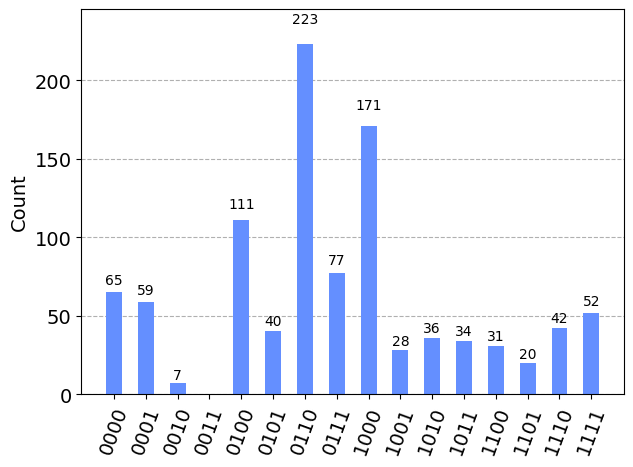

In [40]:
plot_histogram(job_results.result().get_counts())

In [41]:
job_results.result().data()

{'counts': {'0x0': 65,
  '0x8': 171,
  '0x4': 111,
  '0xc': 31,
  '0x2': 7,
  '0xa': 36,
  '0x6': 223,
  '0xe': 42,
  '0x1': 59,
  '0x9': 28,
  '0x5': 40,
  '0xd': 20,
  '0x3': 0,
  '0xb': 34,
  '0x7': 77,
  '0xf': 52},
 'state_pops': {'(0, 0, 0, 0)': 0.06233576399036546,
  '(0, 0, 0, 1)': 0.18045678370310786,
  '(0, 0, 0, 2)': 2.3161421544847867e-05,
  '(0, 0, 1, 0)': 0.10508517822215327,
  '(0, 0, 1, 1)': 0.0376156747671694,
  '(0, 0, 1, 2)': 2.329331933077433e-06,
  '(0, 0, 2, 0)': 1.7122254088009609e-06,
  '(0, 0, 2, 1)': 1.1147675897597992e-05,
  '(0, 0, 2, 2)': 2.5249296524034647e-05,
  '(0, 1, 0, 0)': 0.009544722064919986,
  '(0, 1, 0, 1)': 0.03940909113885947,
  '(0, 1, 0, 2)': 6.45811598456768e-06,
  '(0, 1, 1, 0)': 0.2255019134607583,
  '(0, 1, 1, 1)': 0.03920006260930214,
  '(0, 1, 1, 2)': 2.736872293909243e-06,
  '(0, 1, 2, 0)': 5.632315891668746e-06,
  '(0, 1, 2, 1)': 3.1774700635148885e-06,
  '(0, 1, 2, 2)': 4.0625998125750215e-06,
  '(0, 2, 0, 0)': 2.8915242643420464e-06

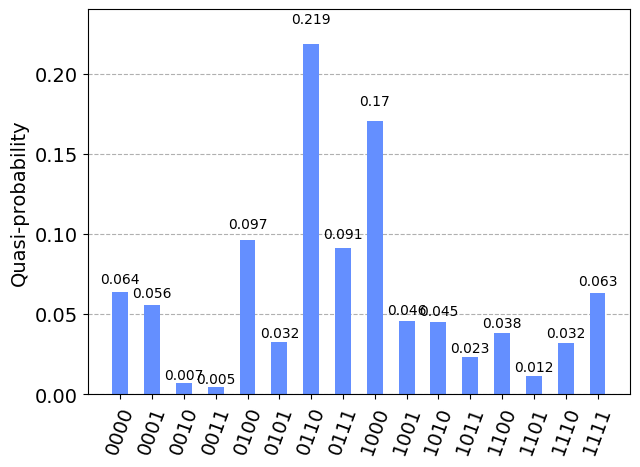

In [42]:
plot_histogram(ideal_results)

In [45]:
from utils import quantum_volume
quantum_volume(qruise_backend, ncircuits=150, nqubits=4, nshots=200)

Quantum Volume: 16
Percentage Heavy Outputs: 83.5%
Passed?: True



True